Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [72]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.regularizers import l2
from keras_preprocessing.image import ImageDataGenerator

In [85]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')
root_path= '/content/gdrive/MyDrive/Colab Notebooks/SkinCancer'
##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
## Download Required dataset
os.chdir(root_path)  #change dir
!unzip -q CNN_assignment.zip  #unzip data/


replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [ ]:
!rm -rf CNN_assignment.zip
!mv Skin\ cancer\ ISIC\ The\ International\ Skin\ Imaging\ Collaboration data

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [105]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
os.chdir(root_path)  #change dir
data_dir_train = pathlib.Path("data/Train")
data_dir_test = pathlib.Path('data/Test')

In [75]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [102]:
batch_size = 32
img_height = 180
img_width = 180
img_size = (img_height, img_height)


Use 80% of the images for training, and 20% for validation.

In [11]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
SEED = 123
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, validation_split=0.2, image_size=(img_height,img_width), subset="training", seed=SEED, batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, validation_split=0.2, image_size=(img_height,img_width), subset="validation",seed=SEED,batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [14]:
# Check if all classes in train and Validate dataset
equivalence_check = train_ds.class_names == val_ds.class_names
assert_fail_message = "Training and Validation classes should match"
assert(equivalence_check), assert_fail_message
class_names = train_ds.class_names
number_classes = len(class_names)

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

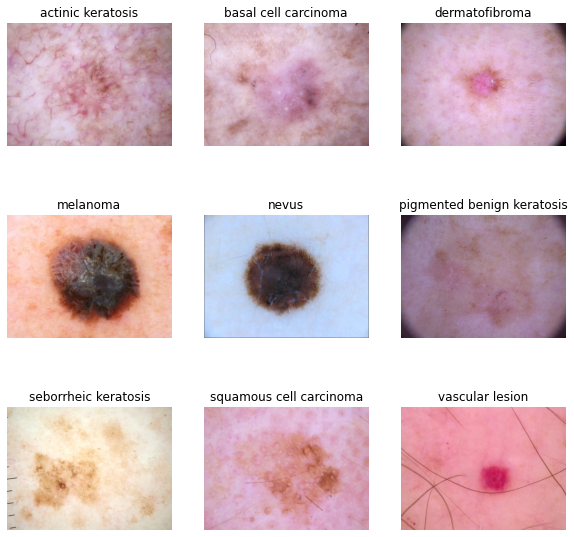

In [19]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [15]:
# For rgb images then the number of colour layers would be 3
number_colour_layers = 3
image_shape = img_size + (number_colour_layers,)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
### Your code goes here
### Preprocessing Layer resize and rescale
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape)
]

In [14]:
### Core layers
def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)

In [15]:
### Dense Layer
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes,activation='softmax')
]

In [16]:
### First Model
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
### Using adam default learning rate 0.001
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [ ]:
### Train the model

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 51s 903ms/step - loss: 1.5630 - accuracy: 0.4587 - val_loss: 1.4361 - val_accuracy: 0.5213
Epoch 2/20
56/56 [==============================] - 50s 891ms/step - loss: 1.2299 - accuracy: 0.5787 - val_loss: 1.4419 - val_accuracy: 0.5235
Epoch 3/20
56/56 [==============================] - 50s 887ms/step - loss: 1.0125 - accuracy: 0.6523 - val_loss: 1.3619 - val_accuracy: 0.5548
Epoch 4/20
56/56 [==============================] - 51s 896ms/step - loss: 0.8608 - accuracy: 0.6948 - val_loss: 1.5509 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 50s 887ms/step - loss: 0.7989 - accuracy: 0.7254 - val_loss: 1.4869 - val_accuracy: 0.5772
Epoch 6/20
56/56 [==============================] - 50s 886ms/step - loss: 0.6568 - accuracy: 0.7740 - val_loss: 1.5126 - val_accuracy: 0.5749
Epoch 7/20
56/56 [==============================] - 55s 987ms/step - loss: 0.5248 - accuracy: 0.8125 - val_loss: 1.8822 - val_accuracy: 0.5861
Epoch 8/20

### Visualizing training results

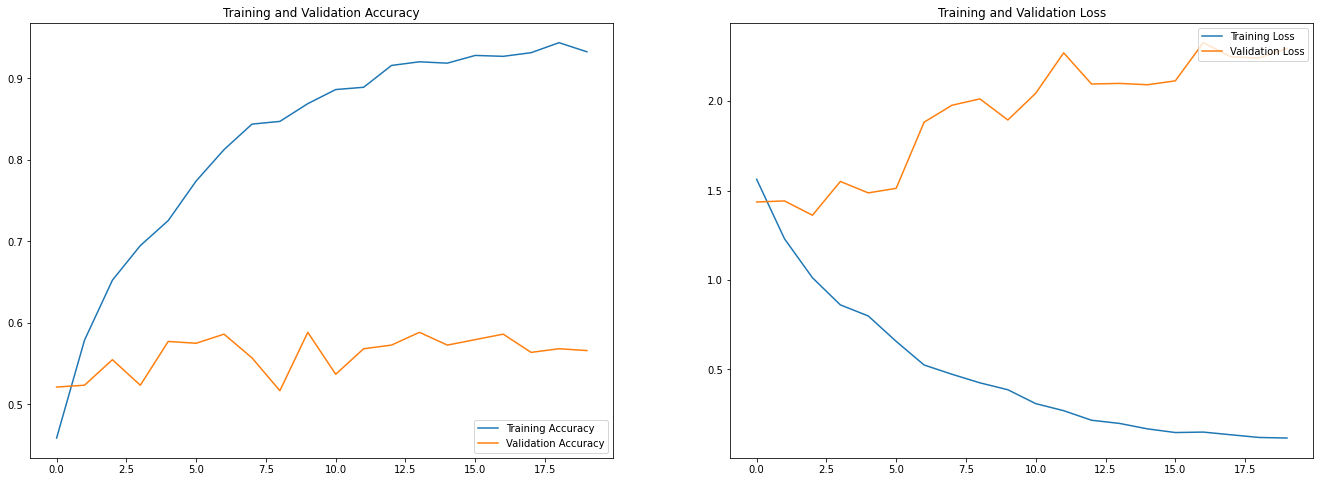

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
### Findings-
- At end of 20 epochs we see very high score in training(93% accuracy) to validation(56.6% accuracy). The difference in accuracy between training and validation accuracy clearly indicated **overfitting**.
- The training accuracy is increasing linearly each epoh, whereas validation accuracy stalls just below 58%.
- Even the loss for validation test kept increasing with every epocs.

**Clear the base model needs to be optimization at various level.**

### What to expect/ to do in next model building -
- Careful control of the conditions in which the data was captured or some **augmentation of the images**.
- In order to avoid overfitting during training we will set the training to stop when it detects no change in loss(when we start to plateau) by **setting lower patience** values during training.

In [21]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
### Addition data augmentation to preprocessing image
data_augmentation = [
  layers.RandomFlip("horizontal_and_vertical",input_shape=(img_height,img_width,3)),
  layers.RandomRotation(0.2,fill_mode='reflect'),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
]
data_aug= tf.keras.Sequential(data_augmentation)
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")


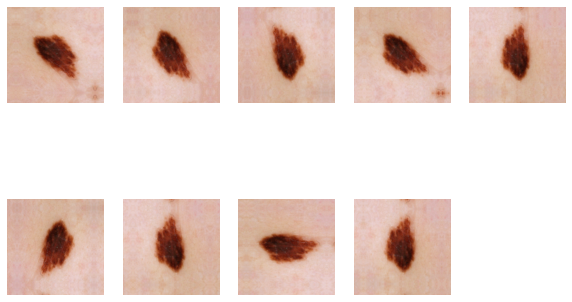

In [22]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_aug(images)
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [57]:
### new Dense Layer with Batch Normalization
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(number_classes,activation='softmax')
]

In [58]:
### New Core layers
### Core layers
def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu',
            kernel_initializer='he_normal',
            kernel_regularizer=l2(0.001),
        ),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
        tf.keras.layers.BatchNormalization()
    ]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers) + \
    conv_2d_pooling_layers(128, number_colour_layers)

In [59]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, verbose=0, mode='max',
    baseline=None, restore_best_weights=True
)

### Second Model
model1 = tf.keras.Sequential(
    preprocessing_layers +
    data_augmentation +
    core_layers +
    dense_layers
)

### Compiling the model

In [60]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
### Using adam default learning rate 0.001
model1.compile(optimizer=adam,
              loss=loss,
              metrics=['accuracy'])

In [61]:
# View the summary of all layers
model1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                 

### Training the model

In [62]:
## Your code goes here, note: train your model for 20 epochs
epochs=30

history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs,
    callbacks = [callback]
)

Epoch 1/30
56/56 [==============================] - 7s 88ms/step - loss: 2.4307 - accuracy: 0.3583 - val_loss: 2.7190 - val_accuracy: 0.1946
Epoch 2/30
56/56 [==============================] - 5s 84ms/step - loss: 2.0528 - accuracy: 0.4503 - val_loss: 3.2292 - val_accuracy: 0.1432
Epoch 3/30
56/56 [==============================] - 5s 83ms/step - loss: 1.8932 - accuracy: 0.5022 - val_loss: 3.3717 - val_accuracy: 0.1007
Epoch 4/30
56/56 [==============================] - 5s 83ms/step - loss: 1.7950 - accuracy: 0.5246 - val_loss: 2.6279 - val_accuracy: 0.2796
Epoch 5/30
56/56 [==============================] - 5s 83ms/step - loss: 1.7022 - accuracy: 0.5491 - val_loss: 1.9921 - val_accuracy: 0.4094
Epoch 6/30
56/56 [==============================] - 5s 84ms/step - loss: 1.6608 - accuracy: 0.5513 - val_loss: 2.2572 - val_accuracy: 0.3557
Epoch 7/30
56/56 [==============================] - 5s 83ms/step - loss: 1.5912 - accuracy: 0.5725 - val_loss: 2.2751 - val_accuracy: 0.4027
Epoch 8/30
56

### Visualizing the results

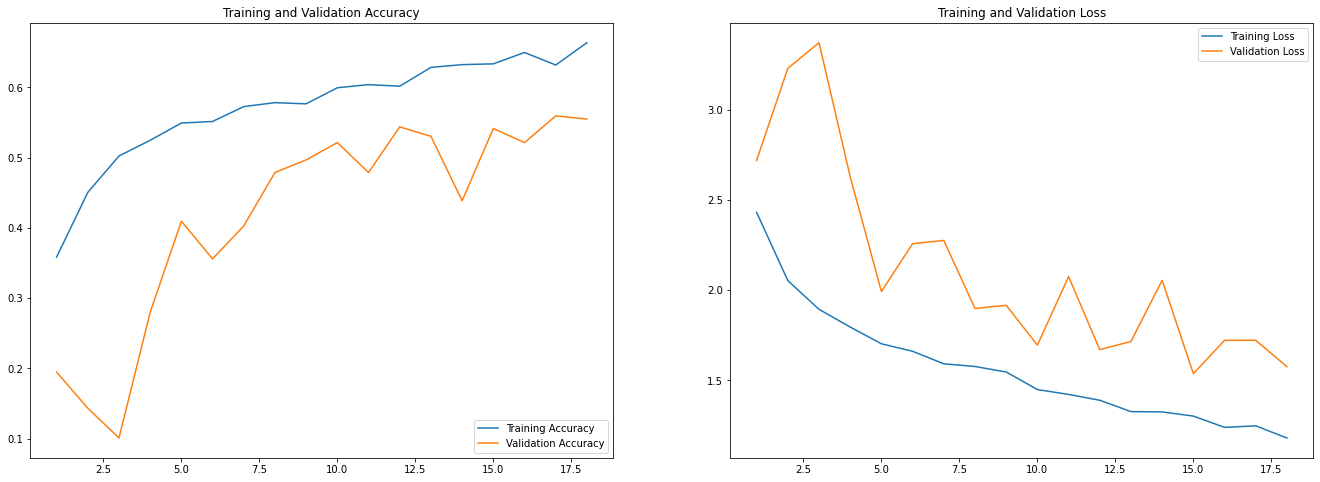

In [65]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(1, len(acc) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### Model findings
- The accuracy has no improved much.
- The overfitting problem has been addressed to a point. But still we need to work on the issue.
- The loss in both training and validation seems to have going down with each epochs.
- Further fine tuning is required to increase the accuracy score. augmentation and class imbalance can also be looked into to further improve the model.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

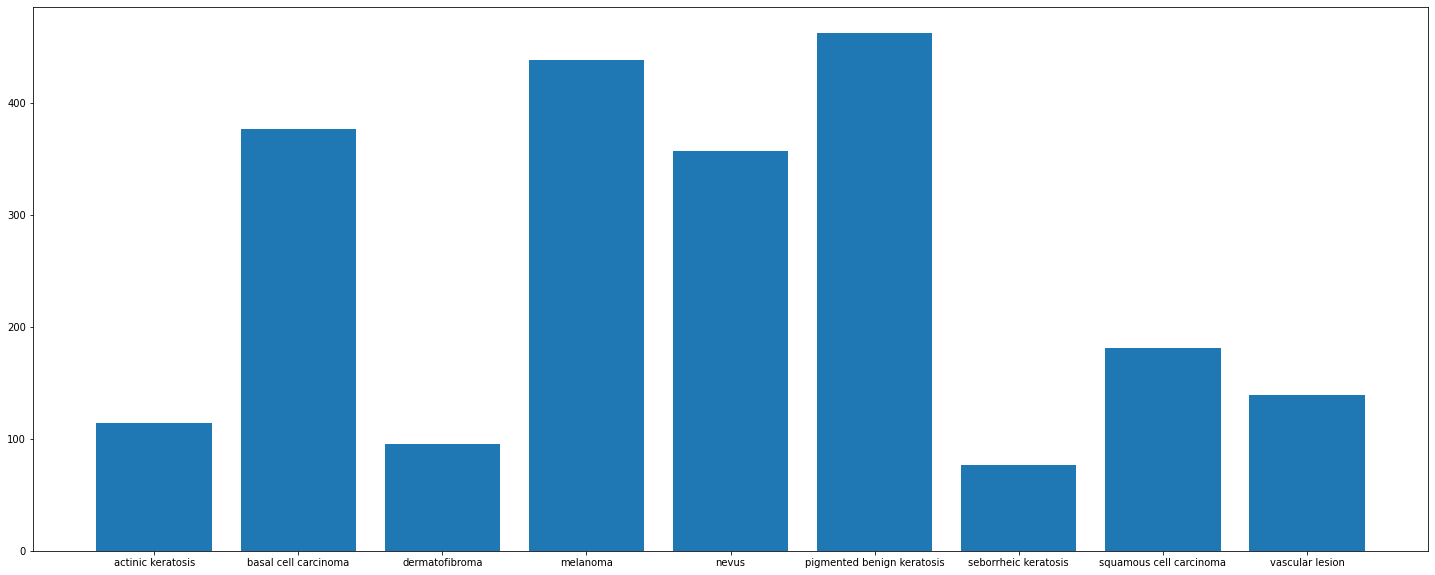

In [66]:
## Your code goes here.
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
  - seborrheic keratosis has the least number of samples
#### - Which classes dominate the data in terms proportionate number of samples?
  - "pigmented benign keratosis" and "melanoma" have proportionate number of samples
  - "basal cell carcinoma" and "nevus" have also proportionate number of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [67]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [88]:
path_to_training_dataset=str(root_path) + "/" +str(data_dir_train)+ "/" 

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3FE9CBA690>: 100%|██████████| 500/500 [00:23<00:00, 21.11 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3F7154C2D0>: 100%|██████████| 500/500 [00:21<00:00, 23.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3F75DC7C10>: 100%|██████████| 500/500 [00:22<00:00, 22.52 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F40655C1250>: 100%|██████████| 500/500 [01:38<00:00,  5.05 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F3F75D9BC50>: 100%|██████████| 500/500 [01:38<00:00,  5.06 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3FE9CBB150>: 100%|██████████| 500/500 [00:21<00:00, 22.82 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F406014C350>: 100%|██████████| 500/500 [00:49<00:00, 10.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40E80502D0>: 100%|██████████| 500/500 [00:21<00:00, 23.56 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F3FE9D62950>: 100%|██████████| 500/500 [00:21<00:00, 23.04 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [89]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [91]:
import os
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_60ec6af0-0fe8-4d15-9658-635c8aac1231.jpg',
 'data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033866.jpg_42d5704f-95c3-4cdc-8bfb-5e966eab5f77.jpg',
 'data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030586.jpg_7f4d6f9b-6996-4204-9952-0dc2a52b7818.jpg',
 'data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_aae3eead-6276-4e86-9b89-969ffd3bdf4e.jpg',
 'data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027334.jpg_04c1d0a4-4734-4ded-aa33-0805a2125045.jpg',
 'data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025992.jpg_6a0a0fa9-ec1b-4f75-af8f-dd80a35c8c1c.jpg',
 'data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031993.jpg_a6a1b667-685b-48b8-880d-d84e13d01d43.jpg',
 'data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027896.jpg_bbf812ff-dc4c-4370-bbe1-7f53882cc8bf.jpg',


In [92]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [97]:
path_list_new=path_list
lesion_list_new=path_list
dataframe_dict_new = dict(zip(path_list_new, path_list_new))

In [98]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df=df2
#new_df = original_df.append(df2)

In [99]:
new_df['Label'].value_counts()

data/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026848.jpg_60ec6af0-0fe8-4d15-9658-635c8aac1231.jpg                      1
data/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026273.jpg_b4afcf68-291a-4e8e-8ca5-0a4702c2b64c.jpg    1
data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_61f3a3fb-6a37-45ff-9d77-d39e5383a579.jpg                1
data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0011095.jpg_a9d0aded-a213-448f-9081-18d824b799f2.jpg                1
data/Train/seborrheic keratosis/output/seborrheic keratosis_original_ISIC_0010942.jpg_b0426b26-44f5-4ee4-a0aa-59bade788fcc.jpg                1
                                                                                                                                             ..
data/Train/melanoma/output/melanoma_original_ISIC_0009955.jpg_367d4e8b-18c1-4282-a16b-0f7df59b0b25.jpg                                  

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [100]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [115]:
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train")
print(data_dir_train1)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

/content/gdrive/MyDrive/Colab Notebooks/SkinCancer/data/Train
Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [118]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [134]:
## your code goes here
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, verbose=0, mode='max',
    baseline=None, restore_best_weights=True
)

### Third Model
model3 = tf.keras.Sequential(
    preprocessing_layers +
    data_augmentation +
    core_layers +
    dense_layers
)

In [135]:
#model3 summary
model3.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [136]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
### Using adam default learning rate 0.001
model3.compile(optimizer=adam,
              loss=loss,
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [137]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs = epochs,
    callbacks = [callback]
)

Epoch 1/30
169/169 [==============================] - 43s 233ms/step - loss: 1.2176 - accuracy: 0.5475 - val_loss: 1.2771 - val_accuracy: 0.5182
Epoch 2/30
169/169 [==============================] - 40s 231ms/step - loss: 1.1878 - accuracy: 0.5556 - val_loss: 1.1906 - val_accuracy: 0.5679
Epoch 3/30
169/169 [==============================] - 40s 230ms/step - loss: 1.1619 - accuracy: 0.5649 - val_loss: 1.1771 - val_accuracy: 0.5561
Epoch 4/30
169/169 [==============================] - 40s 231ms/step - loss: 1.1698 - accuracy: 0.5569 - val_loss: 1.2024 - val_accuracy: 0.5405
Epoch 5/30
169/169 [==============================] - 40s 231ms/step - loss: 1.1526 - accuracy: 0.5662 - val_loss: 1.1714 - val_accuracy: 0.5709
Epoch 6/30
169/169 [==============================] - 40s 232ms/step - loss: 1.1646 - accuracy: 0.5660 - val_loss: 1.5821 - val_accuracy: 0.4774
Epoch 7/30
169/169 [==============================] - 40s 231ms/step - loss: 1.1323 - accuracy: 0.5694 - val_loss: 1.1013 - val_ac

#### **Todo:**  Visualize the model results

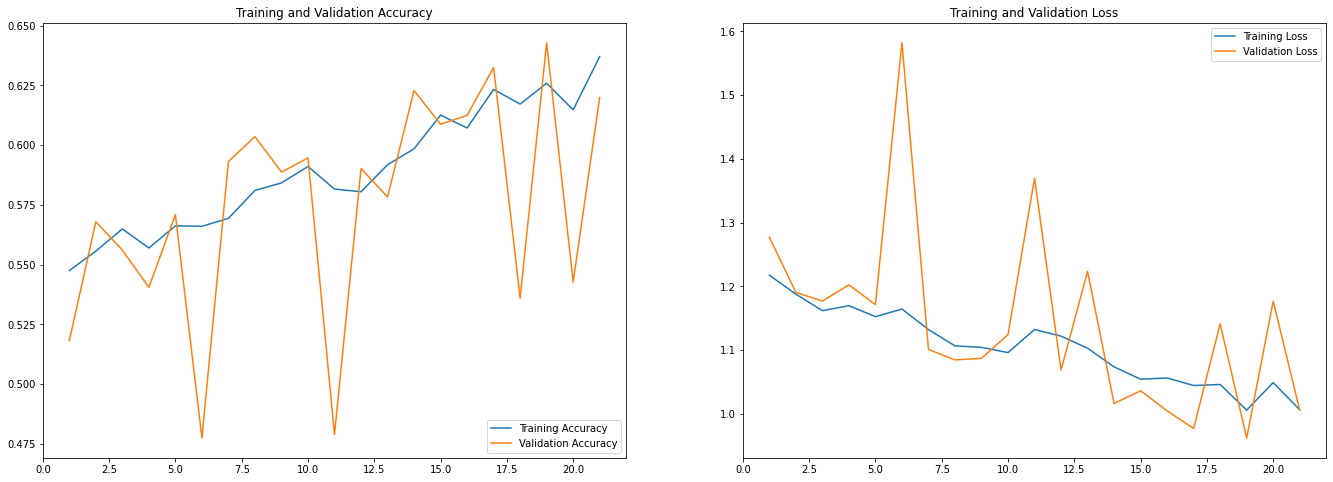

In [140]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(epochs)
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- After managing the class imbalance, augumentor and tuning parameters we can see the Third model performing better than the last two model.
- We had set early stop based on val_loss after 21 epochs.
- We clearly see thr **loss values are on lower side(around 1)** for both training and validation set. For every epocs we see these values going down.
  *  ` train: 1.00      validation: 1.00`
- The **accuracy** for both train and  validation have improved with each epoch
 *  ` train: 0.64       validation: 0.62` 
- Model overfitting issue has improved but the learning rate needs further improvement. This can be resolved by adding more dense layers or more neurons.
- Definitely this model can be further improved by hyperparameter tuning. Also for image classification transfer lerning is best option to use as we can reduce the training time and can also result in lower generalization error.